# GoodReads Top Books Analysis 

This notebook analyzes the GoodReads Top 100 Books (1980–2023) dataset from [Kaggle](https://www.kaggle.com/datasets/cristaliss/ultimate-book-collection-top-100-books-up-to-2023?resource=download). Based on this dataset, I:

- Clean and format the dataset (genres, pages, dates)
- Engineer new features such as decade and popularity index
- Analyze trends in ratings, genres, and book length

In [350]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator, StrMethodFormatter
import math
import calendar

# Loading dataset
books = pd.read_csv("goodreads_top100_from1980to2023_final.csv")

# Preparing data
books.pop("Unnamed: 0")
books = books.drop_duplicates(subset=["isbn", "title"])
books["publication_date"] = pd.to_datetime(books["publication_date"], errors="coerce")
books["num_pages"] = pd.to_numeric(books["num_pages"], errors="coerce").astype("Int64")


display(books.head())


,isbn,title,series_title,series_release_number,authors,publisher,language,description,num_pages,format,genres,publication_date,rating_score,num_ratings,num_reviews,current_readers,want_to_read,price,url
0,9780689830594,Summer Story,Brambly Hedge,2,Jill Barklem,Atheneum,English,It was such a hot summer. The sky was deep blu...,32,Hardcover,"['Picture Books', 'Childrens', 'Fiction', 'Ani...",1980-01-01,4.45,1017.0,74.0,7.0,512.0,3.49,https://www.goodreads.com/book/show/421572.Sum...
1,9780375704970,The Lake of Darkness,NaN,NaN,Ruth Rendell,Vintage Crime/Black Lizard,English,Martin Urban is a quiet bachelor with a comfor...,210,Paperback,"['Mystery', 'Fiction', 'Crime', 'Thriller', 'B...",1980-01-01,3.76,1388.0,114.0,77.0,623.0,4.99,https://www.goodreads.com/book/show/83394.The_...
2,9780345446671,Beyond the Blue Event Horizon,Heechee Saga,2,Frederik Pohl,Ballantine Books,English,"In Book Two of the Heechee Saga, Robinette Bro...",336,Paperback,"['Science Fiction', 'Fiction', 'Space Opera', ...",1980-01-01,3.95,13307.0,339.0,181.0,3961.0,11.99,https://www.goodreads.com/book/show/373399.Bey...
3,9780446403016,St. Peter's Fair,Chronicles of Brother Cadfael,4,Ellis Peters,Mysterious Press,English,A pause in the civil war offers Shrewsbury's t...,217,Mass Market Paperback,"['Mystery', 'Historical Fiction', 'Fiction', '...",1981-05-01,4.12,10493.0,593.0,1298.0,2502.0,0.00,https://www.goodreads.com/book/show/751755.St_...
4,9780425198773,Twice Shy,NaN,NaN,Dick Francis,G.P. Putnam's Sons,English,A computerized horse-betting system falls into...,304,Mass Market Paperback,"['Mystery', 'Fiction', 'Thriller', 'Crime', 'S...",1981-01-01,3.92,4188.0,174.0,162.0,642.0,8.99,https://www.goodreads.com/book/show/103250.Twi...


## SERIES

### What dominates - books from series or separate books?


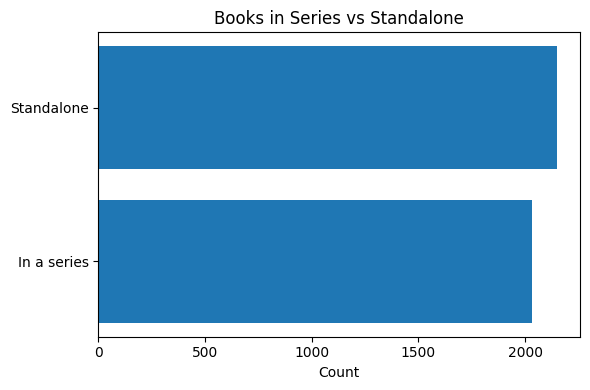

In [311]:
# Number of all books
nr_all_books = (
    books
    .count()["title"]
)

# Number of books without series
nr_books_no_series = (
    books
    .dropna(subset=["series_title"])
    .count()["title"]
)


# Number of books with series
nr_books_in_series = (
    books["series_title"]
    .isna()
    .sum()
)

series_s = pd.Series(
    {"Standalone": nr_books_no_series, "In a series": nr_books_in_series}
)


# Plot
s = series_s.sort_values()  

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(s.index, s.values)

ax.set_xlabel("Count")
ax.set_ylabel("")
ax.set_title("Books in Series vs Standalone")

plt.tight_layout()
plt.show()


### Are there any reoccuring series? 


In [312]:
# Number of unique series names
nr_of_unique_series = (
    len(books["series_title"]
        .dropna()
        .unique())
)

# Reocurring series
top10_reoccuring_series = pd.DataFrame(
    books
    .dropna()
    ["series_title"]
    .value_counts()
    .head(10)
)

display(top10_reoccuring_series)

,count
series_title,
Chronicles of Brother Cadfael,15
Redwall,14
In Death,14
"Harry Bosch, Harry Bosch Universe",13
Vorkosigan Saga,12
The Wheel of Time,12
Mercy Thompson,12
A Series of Unfortunate Events,12
Black Dagger Brotherhood,11


### Do standalone books perform better/worse than series installments?

In [313]:
# Standalones statistics
standalone_stats = (
    books[books["series_title"].isna()]["rating_score"]
        .agg(max_score="max", min_score="min", mean_score="mean", median_score="median", n_titles="size")
        .to_frame().T
)

# In-series statisitcs
inseries_stats = (
    books[books["series_title"].notna()]["rating_score"]
        .agg(max_score="max", min_score="min", mean_score="mean", median_score="median", n_titles="size")
        .to_frame().T
)

# Comparing statistics between standalones and in-series
compare = pd.concat(
    [
        standalone_stats.assign(group="Standalone"),
        inseries_stats.assign(group="In series")
    ],
    axis=0
).set_index("group")

display(compare)


,max_score,min_score,mean_score,median_score,n_titles
group,,,,,
Standalone,4.81,2.97,3.968923,3.98,2033.0
In series,4.76,3.29,4.070377,4.07,2150.0


## AUTHORS

### How many author wrote top books in this period of time?


In [314]:
# Number of authors
nr_author = len(
    books["authors"]
    .unique()
)

print(f"The number of unique authors is {nr_author}")


The number of unique authors is 1906


### Are there any reoccuring authors? 

In [315]:
# Number of reocurring series
top10_reoccuring_authors = pd.DataFrame(
    books
    ["authors"]
    .value_counts()
    .head(10)
)

display(top10_reoccuring_authors)

,count
authors,
Stephen King,48
Nora Roberts,40
Terry Pratchett,36
Neil Gaiman,27
Charlaine Harris,21
John Grisham,20
Patricia Briggs,20
Richelle Mead,19
Rick Riordan,18


### What is the biggest gap between first and last occurence of the author on the list?

In [316]:
# Creating span between first and last author's publication date that occured on the list
span = (
    books.groupby("authors")["publication_date"]
         .agg(first="min", last="max")
)
span["gap_days"] = (span["last"] - span["first"]).dt.days
span["gap_years"] = (span["last"] - span["first"]).dt.days // 365.25

# The longest publications gap
longest = span.sort_values("gap_years", ascending=False).head(1)

display(longest)

,first,last,gap_days,gap_years
authors,,,,
Gabriel García Márquez,1955-01-01,2002-01-01,17167.0,47.0


### What are the highest and lowest ranked authors?

In [317]:
# Authors stats
author_stats = (
    books.groupby("authors")
         .agg(mean_rating=("rating_score", "mean"),
              books_count=("title", "size"))  
)

# Top 10 best rated authors based on average 
top10_best_authors  = author_stats.sort_values("mean_rating", ascending=False).head(10)
display(top10_best_authors)

# Top 10 worst rated authors based on average 
bottom10_worst_authors = author_stats.sort_values("mean_rating", ascending=True).head(10)
display(bottom10_worst_authors)

,mean_rating,books_count
authors,,
Chanel Miller,4.710000,1
Neal Sellers,4.690000,1
James Baldwin,4.670000,1
Anthony Ray Hinton,4.640000,1
Jill Twiss,4.640000,1
Israh Azizi,4.630000,1
Bill Watterson,4.628125,16
Tom Lehrer,4.610000,1
Sergio Cobo,4.590000,1


,mean_rating,books_count
authors,,
Claire Messud,2.97,1
Karen Joy Fowler,3.10,1
Alexandra Everist,3.16,1
Lorrie Moore,3.17,1
Liz Rosenberg,3.20,1
Hanan Al-Shaykh,3.22,1
Robert Goolrick,3.27,1
Ian Caldwell,3.29,1
Seth Grahame-Smith,3.31,1


### Which authors consistently have high-rated books (with at least 5 titles)?

,mean_rating,books_count
authors,,
Bill Watterson,4.628125,16
Brandon Sanderson,4.458889,9
Ilona Andrews,4.445625,16
Sarah J. Maas,4.435000,12
Diana Gabaldon,4.340000,6
J.D. Robb,4.323750,16
Rick Riordan,4.320556,18
Kim Harrison,4.306250,8
Patricia Briggs,4.289000,20


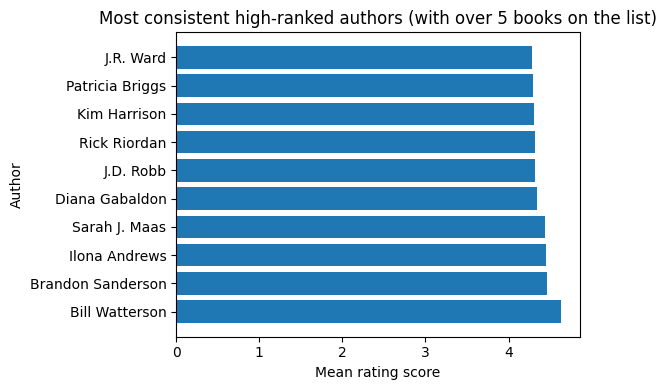

In [318]:
# Top 10 best rated authors based on average 
top10_best_authors_with_over_5books = pd.DataFrame(
    author_stats[author_stats["books_count"]>5]
    .sort_values("mean_rating", ascending=False)
    .head(10))

display(top10_best_authors_with_over_5books)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(top10_best_authors_with_over_5books.index, top10_best_authors_with_over_5books["mean_rating"].values)

ax.set_xlabel("Mean rating score")
ax.set_ylabel("Author")
ax.set_title("Most consistent high-ranked authors (with over 5 books on the list)")

plt.tight_layout()
plt.show()

## PUBLISHERS

### How many publishers occur in the list? 


In [319]:
# Number of all unique publishers
nr_all_publishers = (
    books
    .drop_duplicates(subset=["publisher"])
    .notna()
    .sum()["publisher"]
)

print(f"The number of unique publishers is {nr_all_publishers}.")


The number of unique publishers is 1025.


### What are the most common publisher houses across the list? 

In [320]:
# Top 10 most common publishers
top10_most_common_publishers = pd.DataFrame(
    books
    .value_counts(subset=["publisher"])
    .head(10)
)

display(top10_most_common_publishers)

,count
publisher,
Vintage,98
Ballantine Books,97
Berkley,91
Bantam,71
Penguin Books,58
HarperTeen,53
St. Martin's Press,52
Random House,52
Del Rey,50


### What is the biggest gap between first and last publisher occurence?

In [321]:
# Creating span between first and last publisher's occurence date 
span = (
    books.groupby("publisher")["publication_date"]
         .agg(first="min", last="max")
)
span["gap_days"] = (span["last"] - span["first"]).dt.days
span["gap_years"] = (span["last"] - span["first"]).dt.days // 365.25

# The longest publications gap
longest = span.sort_values("gap_years", ascending=False).head(1)

display(longest)


,first,last,gap_days,gap_years
publisher,,,,
Oxford University Press,1779-01-01,2003-01-01,81814.0,223.0


### What are the best and worst ranked publishers on the list?

In [322]:
# Publishers stats
publishers_stats = (
    books.groupby("publisher")
         .agg(mean_rating=("rating_score", "mean"),
              books_count=("title", "size"))  
)

# Top 10 best rated publishers based on average 
top10_best_publishers_with_over_5books = pd.DataFrame(
    publishers_stats[publishers_stats["books_count"]>5]
    .sort_values("mean_rating", ascending=False)
    .head(10))

display(top10_best_publishers_with_over_5books)

# Bottom 10 worst rated publishers based on average 
top10_worst_publishers_with_over_5books = pd.DataFrame(
    publishers_stats[publishers_stats["books_count"]>5]
    .sort_values("mean_rating", ascending=True)
    .head(10))

display(top10_worst_publishers_with_over_5books)

,mean_rating,books_count
publisher,,
Andrews McMeel Publishing,4.530625,16
DC Comics/Vertigo,4.443333,6
Vertigo,4.358333,6
Bloomsbury Publishing,4.342500,8
Disney-Hyperion Books,4.326667,9
Piatkus,4.281429,7
Forever,4.281111,9
Sphere,4.236667,6
Corgi,4.224000,15


,mean_rating,books_count
publisher,,
Scout Press,3.826667,6
Random House Trade Paperbacks,3.834545,11
Vintage Crime/Black Lizard,3.836250,8
Vintage Books,3.838421,19
Ecco,3.847500,8
Delta,3.857000,10
Riverhead Books,3.859583,24
Park Row,3.871667,6
Faber and Faber,3.877000,10


## GENRES

### Which genres have the highest and lowest median ratings?

C:\Users\natal\AppData\Local\Temp\ipykernel_2492\2363921439.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("Greens")(norm(values))


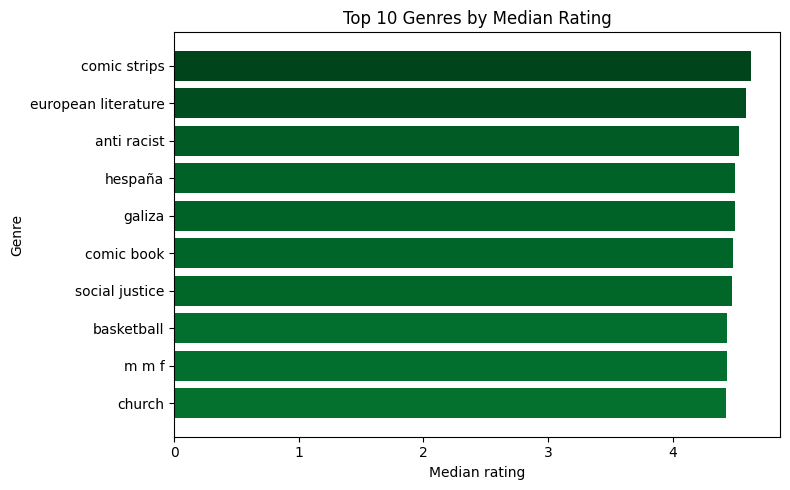

C:\Users\natal\AppData\Local\Temp\ipykernel_2492\2363921439.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("Reds_r")(norm(values))


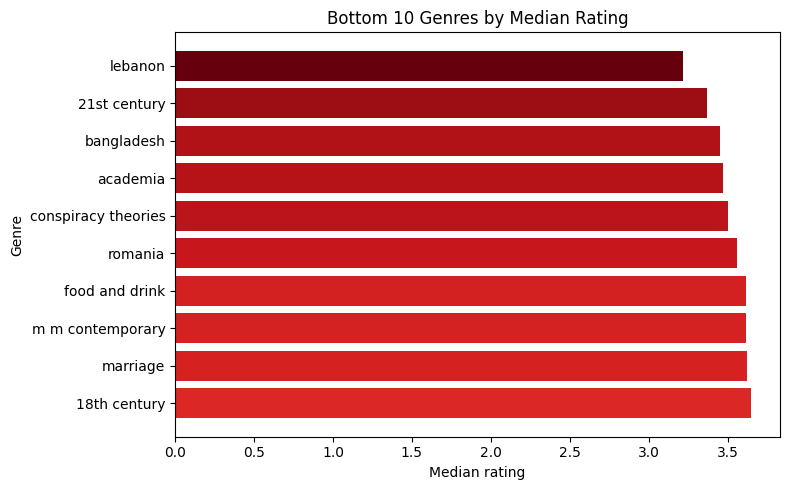

In [323]:
import ast, re

def genres_to_list(x):
    if isinstance(x, list): 
        lst = x
    elif pd.isna(x):
        lst = []
    else:
        s = str(x).strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                lst = ast.literal_eval(s)         
                if isinstance(lst, str): lst = [lst]
            except Exception:
                lst = []
        else:
            lst = re.split(r"[;,|]", s)           
    return [g.strip().strip("'\"").lower() for g in lst if str(g).strip()]

books["genres"] = books["genres"].apply(genres_to_list)

# Top 10 best rated genres based on median 
top10_best_rated_genres = (
    books.explode("genres")
         .dropna(subset=["genres"])
         .groupby("genres")["rating_score"]
         .median()
         .sort_values(ascending=False)
         .head(10)
)


# Top 10 worst rated genres based on median 
bottom10_worst_rated_genres = (
    books.explode("genres")
         .dropna(subset=["genres"])
         .groupby("genres")["rating_score"]
         .median()
         .sort_values(ascending=True)  
         .head(10)
)


vmin = bottom10_worst_rated_genres.values.min()
vmax = top10_best_rated_genres.values.max()
norm = Normalize(vmin=vmin, vmax=vmax)

### TOP 
top_plot = top10_best_rated_genres.sort_values()  

fig, ax = plt.subplots(figsize=(8, 5))
values = top_plot.values
colors = cm.get_cmap("Greens")(norm(values)) 

ax.barh(top_plot.index, values, color=colors, edgecolor="none")
ax.set_xlabel("Median rating")
ax.set_ylabel("Genre")
ax.set_title("Top 10 Genres by Median Rating")
plt.tight_layout()
plt.show()

### BOTTOM
bottom_plot = bottom10_worst_rated_genres.sort_values(ascending=False) 

fig, ax = plt.subplots(figsize=(8, 5))
values = bottom_plot.values
colors = cm.get_cmap("Reds_r")(norm(values))  

ax.barh(bottom_plot.index, values, color=colors, edgecolor="none")
ax.set_xlabel("Median rating")
ax.set_ylabel("Genre")
ax.set_title("Bottom 10 Genres by Median Rating")
plt.tight_layout()
plt.show()

### What are the most common genres?

,title
genres,
fiction,3237
fantasy,1573
romance,1399
contemporary,1006
mystery,953
young adult,949
audiobook,912
historical fiction,759
adult,718


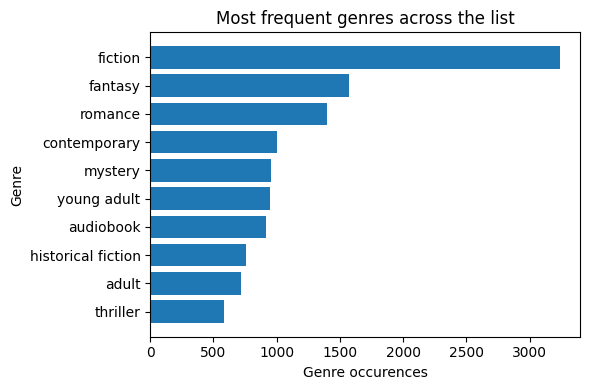

In [324]:
# Top 10 most common genres on the list
top10_most_common_genres = pd.DataFrame(
    books.explode("genres")
         .dropna(subset=["genres"])
         .groupby("genres")["title"]
         .count()
         .sort_values(ascending=False)
         .head(10)
)

display(top10_most_common_genres)

# Plot
top10_most_common_genres_plot = (
    books.explode("genres")
         .dropna(subset=["genres"])
         .groupby("genres")["title"]
         .count()
         .sort_values(ascending=False)
         .head(10)
)

top10_most_common_genres_plot = top10_most_common_genres_plot.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(top10_most_common_genres_plot.index, top10_most_common_genres_plot.values)

ax.set_xlabel("Genre occurences")
ax.set_ylabel("Genre")
ax.set_title("Most frequent genres across the list")

plt.tight_layout()
plt.show()


### Which authors or publishers dominate in specific genres (e.g., top sci-fi or mystery)?

In [325]:
# Preparing dataset
bg = (books
      .explode("genres")
      .dropna(subset=["genres", "authors", "publisher"]))

author_genre_counts = (bg.groupby(["genres", "authors"])["num_ratings"]
                         .sum(min_count=1)
                         .rename("total_ratings")
                         .reset_index())

# Top author for each genre by number of books
top_authors_by_count = (author_genre_counts
                        .sort_values(["genres", "total_ratings"], ascending=[True, False])
                        .groupby("genres")
                        .head(1))
display(top_authors_by_count.head(15))

# Top author for the most common genre by number of books
display(top_authors_by_count.sort_values(by="total_ratings", ascending=False).head(10))

,genres,authors,total_ratings
0,11th century,Dorothy Dunnett,2178.0
1,12th century,Sharon Kay Penman,16510.0
3,15th century,Sharon Kay Penman,21847.0
4,16th century,Alison Weir,27564.0
11,17th century,Philippa Gregory,6111.0
12,18th century,Richard Brinsley Sheridan,381.0
14,19th century,Robert Hughes,9667.0
15,1st grade,Cynthia Rylant,1278.0
27,20th century,Ian McEwan,53657.0
44,21st century,Ali Smith,12586.0


,genres,authors,total_ratings
5763,fiction,J.K. Rowling,34320805.0
14804,young adult,J.K. Rowling,33992781.0
9118,magic,J.K. Rowling,33992781.0
4778,fantasy,J.K. Rowling,33992781.0
2446,childrens,J.K. Rowling,32828710.0
1305,audiobook,J.K. Rowling,32342878.0
9533,middle grade,J.K. Rowling,23598536.0
4223,dystopia,Suzanne Collins,15945101.0
12992,science fiction,Suzanne Collins,15945101.0
11270,paranormal,Stephenie Meyer,13129805.0


In [326]:
pub_genre_eng = (bg.groupby(["genres", "publisher"])["num_ratings"]
                   .sum(min_count=1)
                   .rename("total_ratings")
                   .reset_index())

# Top publisher for each genre by total rating
top_publishers_by_eng = (pub_genre_eng
                         .sort_values(["genres", "total_ratings"], ascending=[True, False])
                         .groupby("genres")
                         .head(1))

display(top_publishers_by_eng.head(15))

# Top publisher for the most common genre by  total rating
display(top_publishers_by_eng.sort_values(by="total_ratings", ascending=False).head(10))

,genres,publisher,total_ratings
0,11th century,Michael Joseph,2178.0
1,12th century,Ballantine Books,16510.0
2,15th century,Ballantine Books,29179.0
3,16th century,Ballantine Books,27564.0
7,17th century,Atria Books,6111.0
10,18th century,Oxford University Press,381.0
12,19th century,Vintage Books,9667.0
13,1st grade,Simon Spotlight,1278.0
14,20th century,Anchor Books/Knopf Doubleday Publishing Group,53657.0
38,21st century,Anchor Books,12586.0


,genres,publisher,total_ratings
5000,fiction,"Little, Brown and Company",20288837.0
12910,young adult,Scholastic Press,17148520.0
4412,fantasy,Scholastic Press,17131369.0
10898,science fiction,Scholastic Press,15945101.0
3641,dystopia,Scholastic Press,15945101.0
10398,romance,"Little, Brown and Company",14157475.0
1034,audiobook,Atria Books,13983795.0
9297,paranormal,"Little, Brown and Company",13950423.0
2558,contemporary,Atria Books,13211047.0
7582,magic,Scholastic Inc,13144357.0


## LANGUAGE

### How many languages appear on the list?

In [327]:
# Number of languages
nr_languages= len(
    books["language"]
    .dropna()
    .unique()
)

print(f"The number of unique languages is {nr_languages}")


The number of unique languages is 8


### What are the top 3 most popular languages across the list?

In [328]:
top3_languages= (
    books
    .groupby("language")["title"]
    .count()
    .sort_values(ascending=False)
    .head(3)
)

display(pd.DataFrame(top3_languages))

,title
language,
English,4126
French,12
Spanish; Castilian,9


### Which languages are the best ranked across the list?

,rating_score
language,
Danish,4.250000
English,4.021561
Dutch; Flemish,4.020000
Spanish; Castilian,4.008889
German,3.950000
French,3.840000
Japanese,3.640000
Portuguese,3.500000


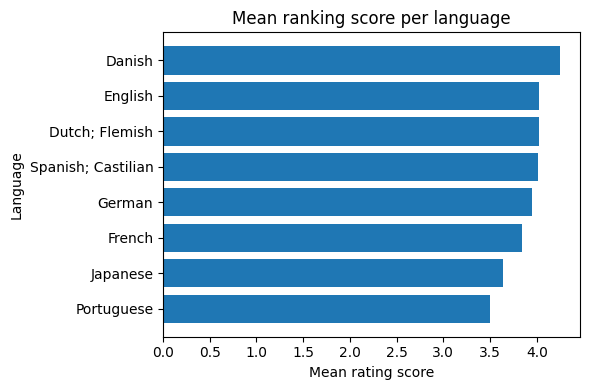

In [329]:
best_ranked_languages= (
    books
    .groupby("language")["rating_score"]
    .mean()
    .sort_values(ascending=False)
)

display(pd.DataFrame(best_ranked_languages))

# Plot
best_ranked_languages = best_ranked_languages.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(best_ranked_languages.index, best_ranked_languages.values)

ax.set_xlabel("Mean rating score")
ax.set_ylabel("Language")
ax.set_title("Mean ranking score per language")

plt.tight_layout()
plt.show()


## NUMBER OF PAGES

### What book length is the most common across GoodReads Top Books?

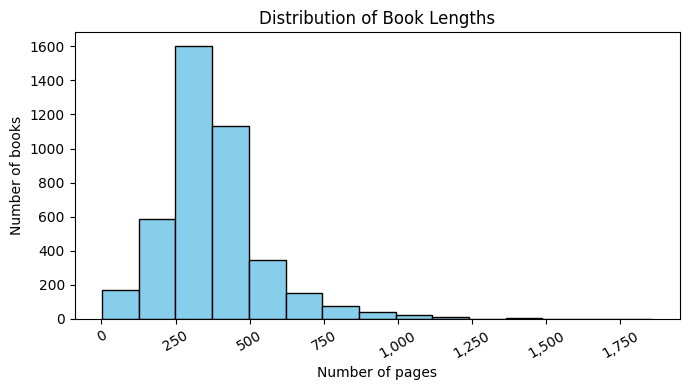

In [330]:
# Plot
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(books["num_pages"].dropna(), bins=15, color="skyblue", edgecolor="black")

ax.set_xlabel("Number of pages")
ax.set_ylabel("Number of books")
ax.set_title("Distribution of Book Lengths")

ax.xaxis.set_major_locator(MaxNLocator(nbins=10))             
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))  
ax.tick_params(axis="x", rotation=30)                         

plt.tight_layout()
plt.show()

### Do longer books (num_pages) receive higher or lower ratings on average?

C:\Users\natal\AppData\Local\Temp\ipykernel_2492\1786039059.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats_rating = (books.groupby("page_bin")["rating_score"]


,page_bin,rating_score
0,0–200,4.037187
1,201–400,3.979718
2,401–600,4.062798
3,601–800,4.109615
4,801–1000,4.190000
5,1000+,4.232381


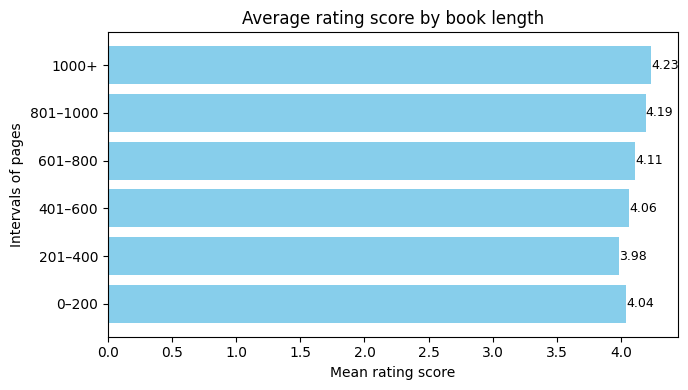

In [331]:
# Bins and labels for histogram
bins = [0, 200, 400, 600, 800, 1000, books["num_pages"].max()]
labels = ["0–200", "201–400", "401–600", "601–800", "801–1000", "1000+"]

books["page_bin"] = pd.cut(books["num_pages"], bins=bins, labels=labels, include_lowest=True)

bin_stats_rating = (books.groupby("page_bin")["rating_score"]
                    .mean()
                    .reset_index()
                    .dropna())

display(pd.DataFrame(bin_stats_rating))

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(bin_stats_rating["page_bin"], bin_stats_rating["rating_score"], color="skyblue")

ax.set_xlabel("Mean rating score")
ax.set_ylabel("Intervals of pages")
ax.set_title("Average rating score by book length")

for i, v in enumerate(bin_stats_rating["rating_score"]):
    ax.text(v, i, f"{v:.2f}", va="center", ha="left", fontsize=9)

plt.tight_layout()
plt.show()


### Is there a typical page range for the most popular books?

   page_bin    num_ratings
0     0–200   64739.069712
1   201–400  143272.032079
2   401–600  169682.525310
3   601–800  195824.799145
4  801–1000  217052.094595
5     1000+  168656.833333


C:\Users\natal\AppData\Local\Temp\ipykernel_2492\4027029169.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats_nr_ratings = (books.groupby("page_bin")["num_ratings"]


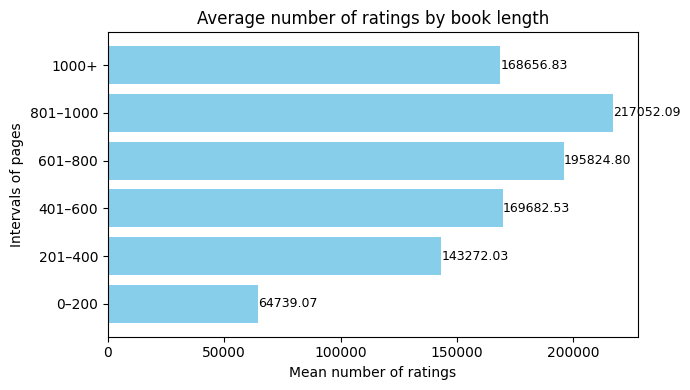

In [332]:
bin_stats_nr_ratings = (books.groupby("page_bin")["num_ratings"]
                    .mean()
                    .reset_index()
                    .dropna())

print(bin_stats_nr_ratings)

fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(bin_stats_nr_ratings["page_bin"], bin_stats_nr_ratings["num_ratings"], color="skyblue")

ax.set_xlabel("Mean number of ratings")
ax.set_ylabel("Intervals of pages")
ax.set_title("Average number of ratings by book length")

for i, v in enumerate(bin_stats_nr_ratings["num_ratings"]):
    ax.text(v, i, f"{v:.2f}", va="center", ha="left", fontsize=9)

plt.tight_layout()
plt.show()

### Are the specific lengths of books more common in certain genres?

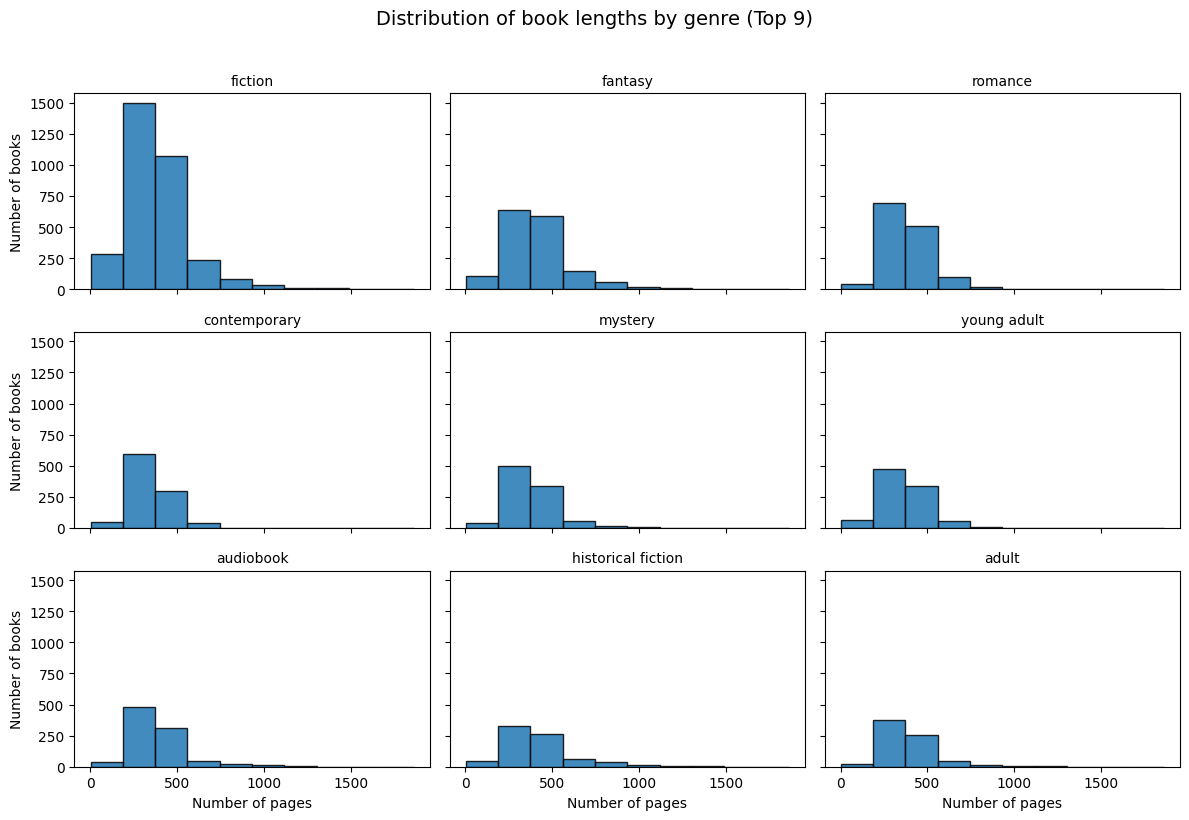

In [333]:
# Choosing top 9 genres for facets
top9_most_common_genres = pd.DataFrame(
    books.explode("genres")
         .dropna(subset=["genres"])
         .groupby("genres")["title"]
         .count()
         .sort_values(ascending=False)
         .head(9)
)

top_genres = top9_most_common_genres.index.tolist()

# Saving only the data from chosen genres
bg = (books
      .explode("genres")
      .dropna(subset=["genres", "num_pages"]))

bg = bg[bg["genres"].isin(top_genres)].copy()
bg = bg.dropna(subset=["num_pages"])

# Common bins across all panels so shapes are comparable
bins = np.histogram_bin_edges(bg["num_pages"], bins=10)

# Creating faceted histograms
n = len(top_genres)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

for i, g in enumerate(top_genres):
    ax = axes[i]
    data = bg.loc[bg["genres"] == g, "num_pages"]
    ax.hist(data, bins=bins, edgecolor="black", alpha=0.85)  
    ax.set_title(g, fontsize=10)
    if i % ncols == 0:
        ax.set_ylabel("Number of books")
    if i >= n - ncols:
        ax.set_xlabel("Number of pages")

# Hide any unused axes (if n not multiple of ncols)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Distribution of book lengths by genre (Top 9)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## FORMAT

### How does the distribution of ratings vary between formats (Hardcover vs. Paperback vs. Kindle)?

,count
format,
Paperback,1689
Hardcover,1328
Mass Market Paperback,679
Kindle Edition,264
ebook,128


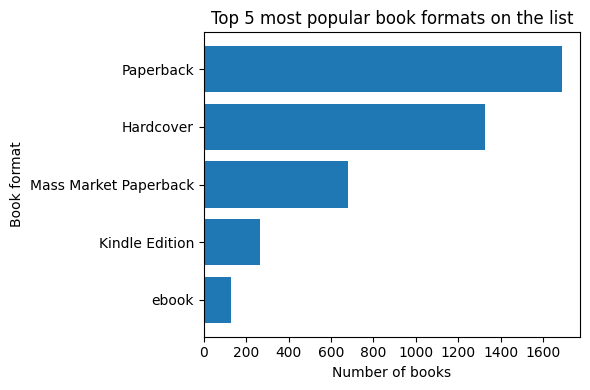

In [334]:
# Top 5 most common formats
top5_common_formats = (
    books["format"]
    .value_counts()
    .sort_values(ascending=False)
    .head(5)
)

display(pd.DataFrame(top5_common_formats))

# Plot
top5_common_formats = top5_common_formats.sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(top5_common_formats.index, top5_common_formats.values)

ax.set_xlabel("Number of books")
ax.set_ylabel("Book format")
ax.set_title("Top 5 most popular book formats on the list")

plt.tight_layout()
plt.show()

### How does book format influence ratings?

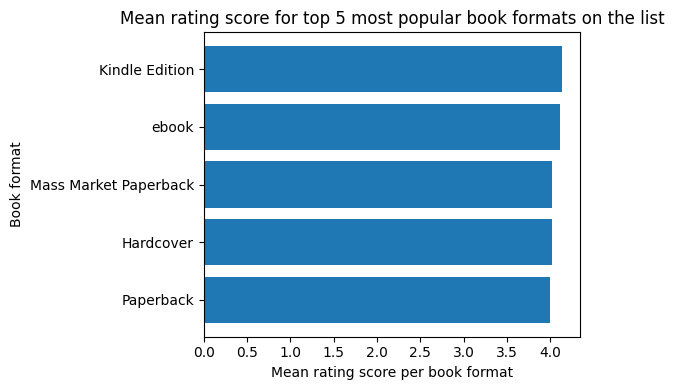

In [335]:
# Top 5 most common formats
top5_common_formats_names = top5_common_formats.index.tolist()

# Saving only the data from chosen genres
bg = (books
      .explode("format")
      .dropna(subset=["format", "rating_score"]))

bg = bg[bg["format"].isin(top5_common_formats_names)].copy()
bg = bg.dropna(subset=["rating_score"])

format_ratings = (
    bg
    .groupby("format")["rating_score"]
    .mean()
)

# Plot
format_ratings = format_ratings.sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(format_ratings.index, format_ratings.values)

ax.set_xlabel("Mean rating score per book format")
ax.set_ylabel("Book format")
ax.set_title("Mean rating score for top 5 most popular book formats on the list")

plt.tight_layout()
plt.show()

## MORE STATISTICS

### Are books with more reviews rated differently than those with fewer?

C:\Users\natal\AppData\Local\Temp\ipykernel_2492\204529966.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  books.groupby("num_reviews_bin")["rating_score"]


        num_reviews_bin  mean_rating  nr_of_books
0     (-0.001, 25910.9]     4.011832         3832
1    (25910.9, 51821.8]     4.100596          218
2    (51821.8, 77732.7]     4.122609           69
3   (77732.7, 103643.6]     4.199063           32
4  (103643.6, 129554.5]     4.085000           16
5  (129554.5, 155465.4]     4.306000            5
6  (155465.4, 181376.3]     4.258571            7
7  (181376.3, 207287.2]     4.390000            1
8  (207287.2, 233198.1]     4.330000            1
9  (233198.1, 259109.0]     4.305000            2


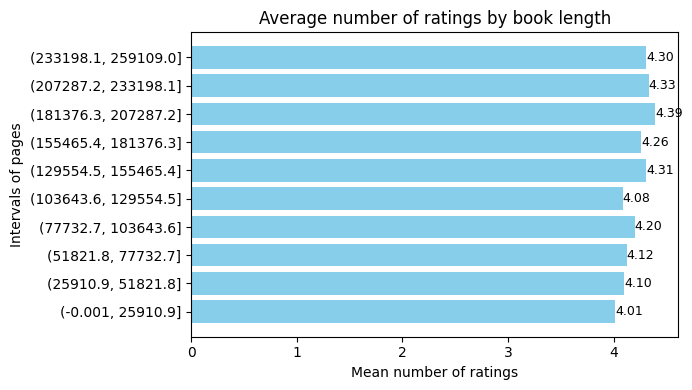

In [336]:
# Common bins across all panels so shapes are comparable
bins = np.histogram_bin_edges(books["num_reviews"].dropna(), bins=10)
books["num_reviews_bin"] = pd.cut(books["num_reviews"], bins=bins, include_lowest=True)


bin_stats_ratings_rev = (
    books.groupby("num_reviews_bin")["rating_score"]
                    .agg(mean_rating="mean", nr_of_books = "size")
                    .reset_index()
                    .dropna()
                    .sort_values("num_reviews_bin"))

print(bin_stats_ratings_rev)

fig, ax = plt.subplots(figsize=(7, 4))
ax.barh(bin_stats_ratings_rev["num_reviews_bin"].astype(str), bin_stats_ratings_rev["mean_rating"], color="skyblue")

ax.set_xlabel("Mean number of ratings")
ax.set_ylabel("Intervals of pages")
ax.set_title("Average number of ratings by book length")

for i, v in enumerate(bin_stats_ratings_rev["mean_rating"]):
    ax.text(v, i, f"{v:.2f}", va="center", ha="left", fontsize=9)

plt.tight_layout()
plt.show()


### What is the relationship between rating_score and num_ratings (does popularity correlate with quality)?

Pearson correlation: 0.12376474201211338
Spearman correlation: 0.17446347768486364


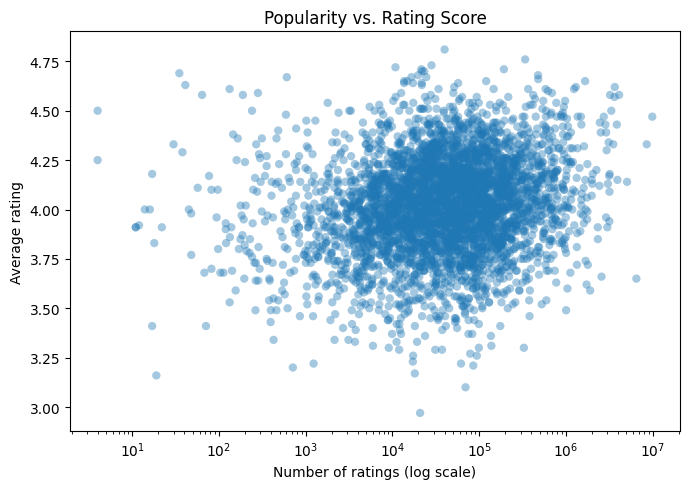

In [337]:
corr_p = books["rating_score"].corr(books["num_ratings"], method="pearson")
print("Pearson correlation:", corr_p)

corr_s = books["rating_score"].corr(books["num_ratings"], method="spearman")
print("Spearman correlation:", corr_s)

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(books["num_ratings"], books["rating_score"], alpha=0.4, edgecolor="none")

ax.set_xscale("log")  # ratings counts usually very skewed, log-scale helps
ax.set_xlabel("Number of ratings (log scale)")
ax.set_ylabel("Average rating")
ax.set_title("Popularity vs. Rating Score")

plt.tight_layout()
plt.show()

### How have average ratings changed across decades (1980s → 2020s)?

,decade,mean_rating,nr_of_books
0,1770,3.650000,1
1,1910,4.140000,1
2,1940,4.240000,1
3,1950,4.223333,3
4,1960,4.012000,5
5,1970,3.951250,8
6,1980,4.006581,816
7,1990,4.004337,966
8,2000,3.971514,984
9,2010,4.081695,991


,decade,mean_rating,nr_of_books
9,2010,4.081695,991
8,2000,3.971514,984
7,1990,4.004337,966
6,1980,4.006581,816
10,2020,4.063868,393


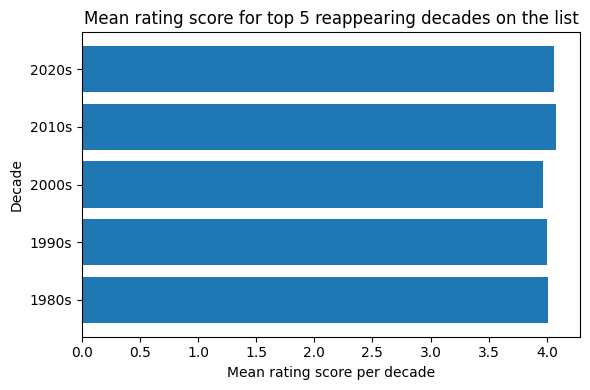

In [338]:
books["pub_year"] = books["publication_date"].dt.year.astype("Int64")
books["decade"]   = (books["pub_year"] // 10) * 10

decade_stats = (
    books.groupby("decade")["rating_score"]
                    .agg(mean_rating="mean", nr_of_books = "size")
                    .reset_index()
                    .dropna()
                    .sort_values("decade"))

display(pd.DataFrame(decade_stats))

top5_decade_stats = (
    decade_stats
    .sort_values("nr_of_books", ascending=False)
    .head(5)
)

display(pd.DataFrame(top5_decade_stats))

# Plot
top5_decade_stats = top5_decade_stats.sort_values("decade", ascending=True)
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(top5_decade_stats["decade"].astype(str)+"s", top5_decade_stats["mean_rating"])

ax.set_xlabel("Mean rating score per decade")
ax.set_ylabel("Decade")
ax.set_title("Mean rating score for top 5 reappearing decades on the list")

plt.tight_layout()
plt.show()

### Which decade produced the highest and lowest rated books?

,decade,max_rank,min_rank,nr_of_books
10,2020,4.72,3.29,393
9,2010,4.76,3.30,991
8,2000,4.81,2.97,984
7,1990,4.73,3.31,966
6,1980,4.67,3.22,816


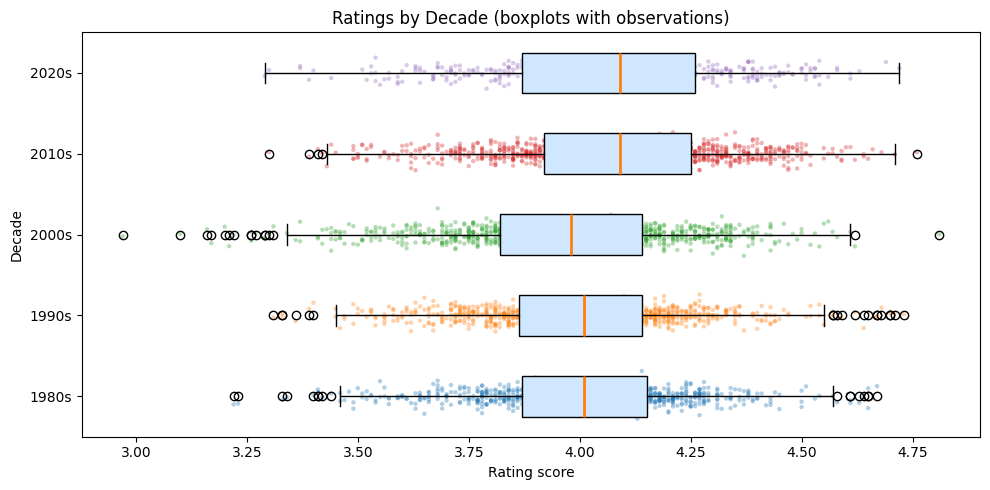

In [339]:
decade_stats_adv = (
    books.groupby("decade")["rating_score"]
                    .agg(max_rank="max", min_rank = "min", nr_of_books = "size")
                    .reset_index()
                    .dropna()
                    .sort_values("decade", ascending=False)
                    .head(5))

display(pd.DataFrame(decade_stats_adv))

# Preparing data for boxplot
df = books.dropna(subset=["decade", "rating_score"]).copy()
decades = np.sort(df["decade"].unique())[6:11]              # sorted decade labels
data = [df.loc[df["decade"] == d, "rating_score"].values for d in decades]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

bp = ax.boxplot(
    data,
    positions=range(len(decades)),
    vert=False,          # horizontal (easier labels)
    patch_artist=True,   # allow facecolor fill
    showfliers=True,     # keep to highlight outliers
    medianprops=dict(linewidth=2),
)

# simple fill for boxes
for box in bp["boxes"]:
    box.set_facecolor("#cfe8ff")

# overlay points with jitter
for i, vals in enumerate(data):
    x = vals
    y = np.random.normal(loc=i, scale=0.08, size=len(vals))  # jitter around each decade
    ax.scatter(x, y, s=10, alpha=0.35, edgecolors="none")

# labels/ticks
ax.set_yticks(range(len(decades)))
ax.set_yticklabels([f"{d}s" for d in decades])
ax.set_xlabel("Rating score")
ax.set_ylabel("Decade")
ax.set_title("Ratings by Decade (boxplots with observations)")

plt.tight_layout()
plt.show()

### Are newer books receiving more want-to-read marks compared to older ones?

,decade,max_want,min_want,nr_of_books
10,2020,1000000.0,7.0,393
9,2010,2000000.0,34.0,991
8,2000,2000000.0,9.0,984
7,1990,2000000.0,3.0,966
6,1980,2000000.0,7.0,816


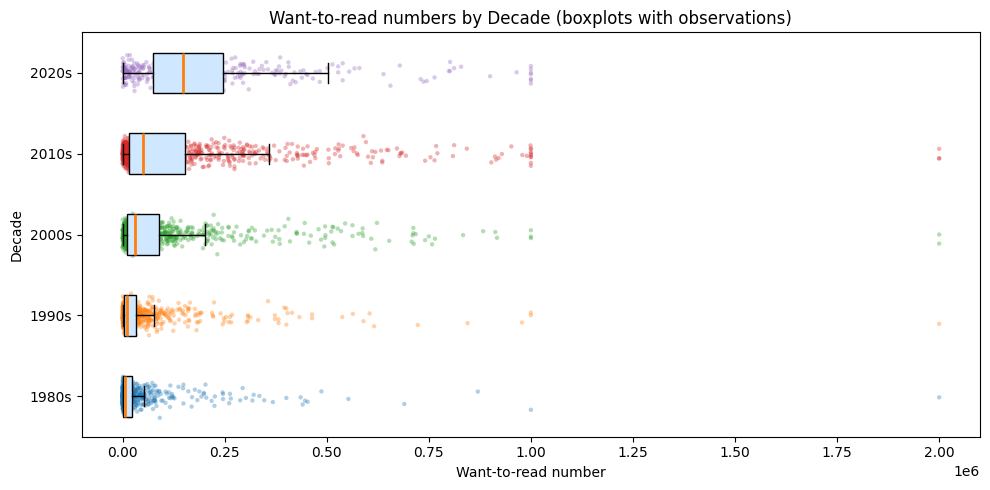

In [340]:
decade_stats_btr = (
    books.groupby("decade")["want_to_read"]
                    .agg(max_want="max", min_want = "min", nr_of_books = "size")
                    .reset_index()
                    .dropna()
                    .sort_values("decade", ascending=False)
                    .head(5))

display(pd.DataFrame(decade_stats_btr))

# Preparing data for boxplot
df = books.dropna(subset=["decade", "want_to_read"]).copy()
decades = np.sort(df["decade"].unique())[6:11]              # sorted decade labels
data = [df.loc[df["decade"] == d, "want_to_read"].values for d in decades]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

bp = ax.boxplot(
    data,
    positions=range(len(decades)),
    vert=False,          # horizontal (easier labels)
    patch_artist=True,   # allow facecolor fill
    showfliers=False,     # keep to highlight outliers
    medianprops=dict(linewidth=2),
)

# simple fill for boxes
for box in bp["boxes"]:
    box.set_facecolor("#cfe8ff")

# overlay points with jitter
for i, vals in enumerate(data):
    x = vals
    y = np.random.normal(loc=i, scale=0.08, size=len(vals))  # jitter around each decade
    ax.scatter(x, y, s=10, alpha=0.35, edgecolors="none")

# labels/ticks
ax.set_yticks(range(len(decades)))
ax.set_yticklabels([f"{d}s" for d in decades])
ax.set_xlabel("Want-to-read number")
ax.set_ylabel("Decade")
ax.set_title("Want-to-read numbers by Decade (boxplots with observations)")

plt.tight_layout()
plt.show()

### Do publication months show seasonality (e.g., more high-rated books in fall)?

C:\Users\natal\AppData\Local\Temp\ipykernel_2492\3781240556.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["engagement"]


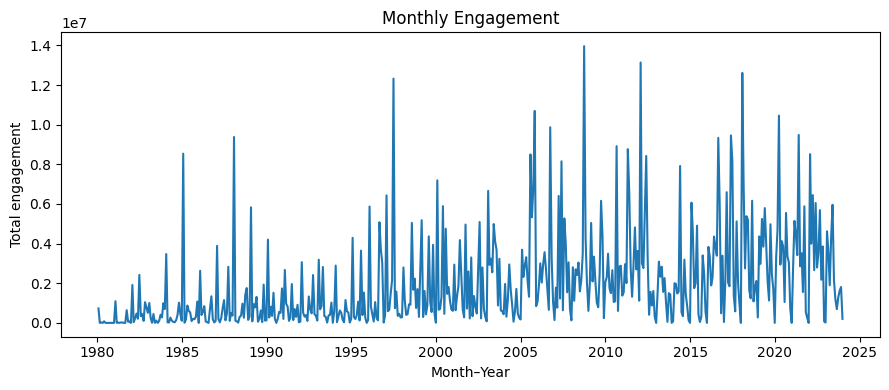

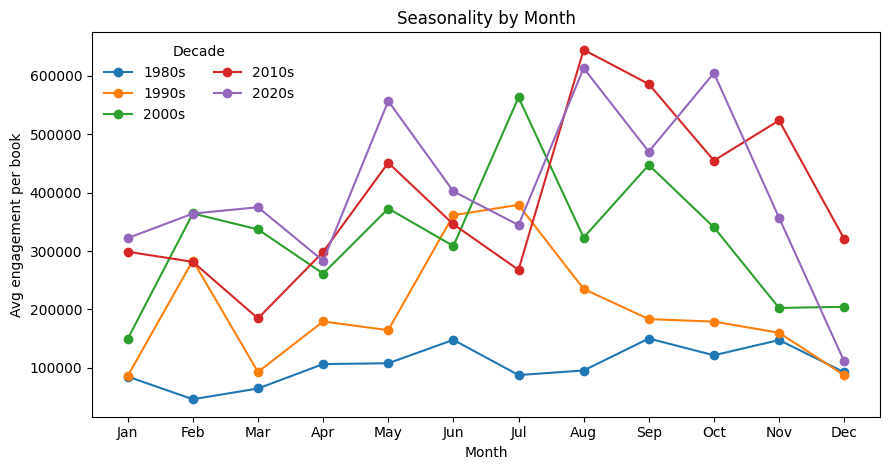

In [ ]:
# Creating new column - endgagement - as sum of readers evaluations
books["engagement"] = books["num_ratings"].fillna(0) + books["num_reviews"].fillna(0) + books["current_readers"].fillna(0) + books["want_to_read"].fillna(0)
books_80_20 = books.loc[books["decade"].between(1980, 2020)].copy()

# Visualization of time-trend
monthly_eng = (books_80_20
    .dropna(subset=["publication_date"])
    .set_index("publication_date")
    .resample("M")["engagement"]
    .sum()
)

fig, ax = plt.subplots(figsize=(9,4))
ax.plot(monthly_eng.index, monthly_eng.values)
ax.set_xlabel("Month–Year")
ax.set_ylabel("Total engagement")
ax.set_title("Monthly Engagement")
plt.tight_layout()
plt.show()

# Ensure needed columns exist
books_80_20 = books_80_20.dropna(subset=["publication_date"]).copy()
books_80_20["pub_year"]  = books_80_20["publication_date"].dt.year
books_80_20["month"]     = books_80_20["publication_date"].dt.month

# Average engagement per *book* for each (decade, month)
moy_decade = (books_80_20
    .groupby(["decade", "month"])["engagement"]
    .mean()                                   
    .reset_index())

# Plot: one colored line per decade
fig, ax = plt.subplots(figsize=(9, 4.8))
for dec, g in moy_decade.groupby("decade"):
    g = g.sort_values("month")
    ax.plot(g["month"], g["engagement"], marker="o", label=f"{dec}s")

ax.set_xticks(range(1,13))
ax.set_xticklabels([calendar.month_abbr[m] for m in range(1,13)])
ax.set_xlabel("Month")
ax.set_ylabel("Avg engagement per book")
ax.set_title("Seasonality by Month")
ax.legend(title="Decade", ncol=2, frameon=False)
plt.tight_layout()
plt.show()
